In [ ]:
# Helper Functions 
import zipfile
import datetime
def unzip_data(filename):

  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()



def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
      will be used.

      Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

      Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

      Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """  
    # Create the confustion matrix
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if norm:
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
      else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow 
import pathlib
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# read examples of images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#preprocessing
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
!wget /content/sample_data/Mosquito-on-human-skin.zip

unzip_data("/content/sample_data/Mosquito-on-human-skin.zip")

train_dir = "/content/zw4p9kj6nt-2/data_splitting/Train/"
valid_dir ="/content/zw4p9kj6nt-2/data_splitting/Pred/"
test_dir = "/content/zw4p9kj6nt-2/data_splitting/Test/"

/content/sample_data/Mosquito-on-human-skin.zip: Scheme missing.


In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Culex landing' 'Culex smashed' 'aegypti landing' 'aegypti smashed'
 'albopictus landing' 'albopictus smashed']


In [ ]:
# Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/zw4p9kj6nt-2/data_splitting/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/zw4p9kj6nt-2/data_splitting/'.
There are 6 directories and 0 images in '/content/zw4p9kj6nt-2/data_splitting/Train'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/albopictus smashed'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/aegypti smashed'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/albopictus landing'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/aegypti landing'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/Culex smashed'.
There are 0 directories and 700 images in '/content/zw4p9kj6nt-2/data_splitting/Train/Culex landing'.
There are 6 directories and 0 images in '/content/zw4p9kj6nt-2/data_splitting/Test'.
There are 0 directories and 300 images in '/content/zw4p9kj6nt-2/data_splitting/Test/albopictus smashed'.
There are 0 dire

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


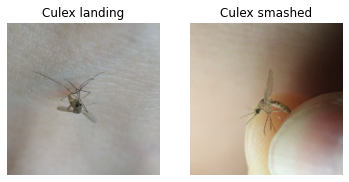

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
Culex_landing = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "Culex landing")
plt.subplot(1, 2, 2)
Culex_smashed = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "Culex smashed")

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


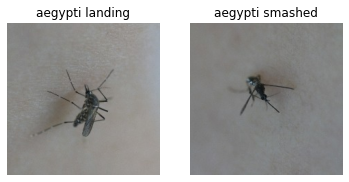

In [ ]:
plt.subplot(1, 2, 1)
aegypti_landing = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "aegypti landing")
plt.subplot(1, 2, 2)
aegypti_smashed = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "aegypti smashed")

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


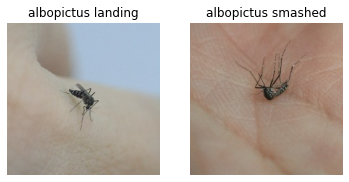

In [ ]:
plt.subplot(1, 2, 1)
albopictus_landing = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "albopictus landing")
plt.subplot(1, 2, 2)
albopictus_smashed = view_random_image("/content/zw4p9kj6nt-2/data_splitting/Train/", "albopictus smashed")

In [ ]:
# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",shuffle=False)

Found 4200 files belonging to 6 classes.
Found 3600 files belonging to 6 classes.
Found 1799 files belonging to 6 classes.


In [ ]:
train_data.class_names

['Culex landing',
 'Culex smashed',
 'aegypti landing',
 'aegypti smashed',
 'albopictus landing',
 'albopictus smashed']

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB5(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(6, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        # Track model training logs
                        callbacks=[create_tensorboard_callback("CNN_learning", "transfer_learning_data")])

Shape after base_model: (None, 7, 7, 2048)
After GlobalAveragePooling2D(): (None, 2048)
Saving TensorBoard log files to: CNN_learning/transfer_learning_data/20220804-093008
Epoch 1/10
132/132 [==============================] - 87s 436ms/step - loss: 1.1765 - accuracy: 0.5636 - val_loss: 0.8931 - val_accuracy: 0.6961
Epoch 2/10
132/132 [==============================] - 54s 410ms/step - loss: 0.8108 - accuracy: 0.7255 - val_loss: 0.7204 - val_accuracy: 0.7603
Epoch 3/10
132/132 [==============================] - 54s 406ms/step - loss: 0.6796 - accuracy: 0.7664 - val_loss: 0.6412 - val_accuracy: 0.7806
Epoch 4/10
132/132 [==============================] - 54s 409ms/step - loss: 0.6031 - accuracy: 0.8069 - val_loss: 0.5642 - val_accuracy: 0.8253
Epoch 5/10
132/132 [==============================] - 54s 406ms/step - loss: 0.5423 - accuracy: 0.8269 - val_loss: 0.5091 - val_accuracy: 0.8481
Epoch 6/10
132/132 [==============================] - 54s 408ms/step - loss: 0.5100 - accuracy: 0.8393

In [ ]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 6)                 12294     
                                                                 
Total params: 28,525,821
Trainable params: 12,294
Non-trainable params: 28,513,527
_________________________________________________________________


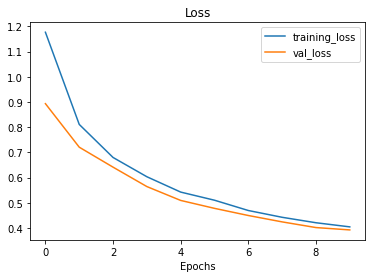

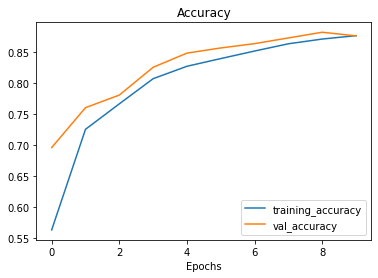

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_1)

In [ ]:
# Make predictions with model
pred_probs = model_1.predict(test_data, verbose=1) # set verbosity to see how long it will take 

57/57 [==============================] - 15s 210ms/step


In [ ]:
# How many predictions are there?
len(pred_probs)

1799

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(1799, 6)

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 6
What prediction probability sample 0 looks like:
 [0.42638648 0.0159199  0.11374429 0.4310778  0.01065191 0.00221957]
The class with the highest predicted probability by the model for sample 0: 3


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([3, 3, 1, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pd.DataFrame({"True Labels":y_labels,"Predictions":pred_classes})

,True Labels,Predictions
0,0,3
1,0,3
2,0,1
3,0,1
4,0,0
...,...,...
1794,5,5
1795,5,5
1796,5,5
1797,5,3


In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8454697053918844

In [ ]:
class_names_test =test_data.class_names

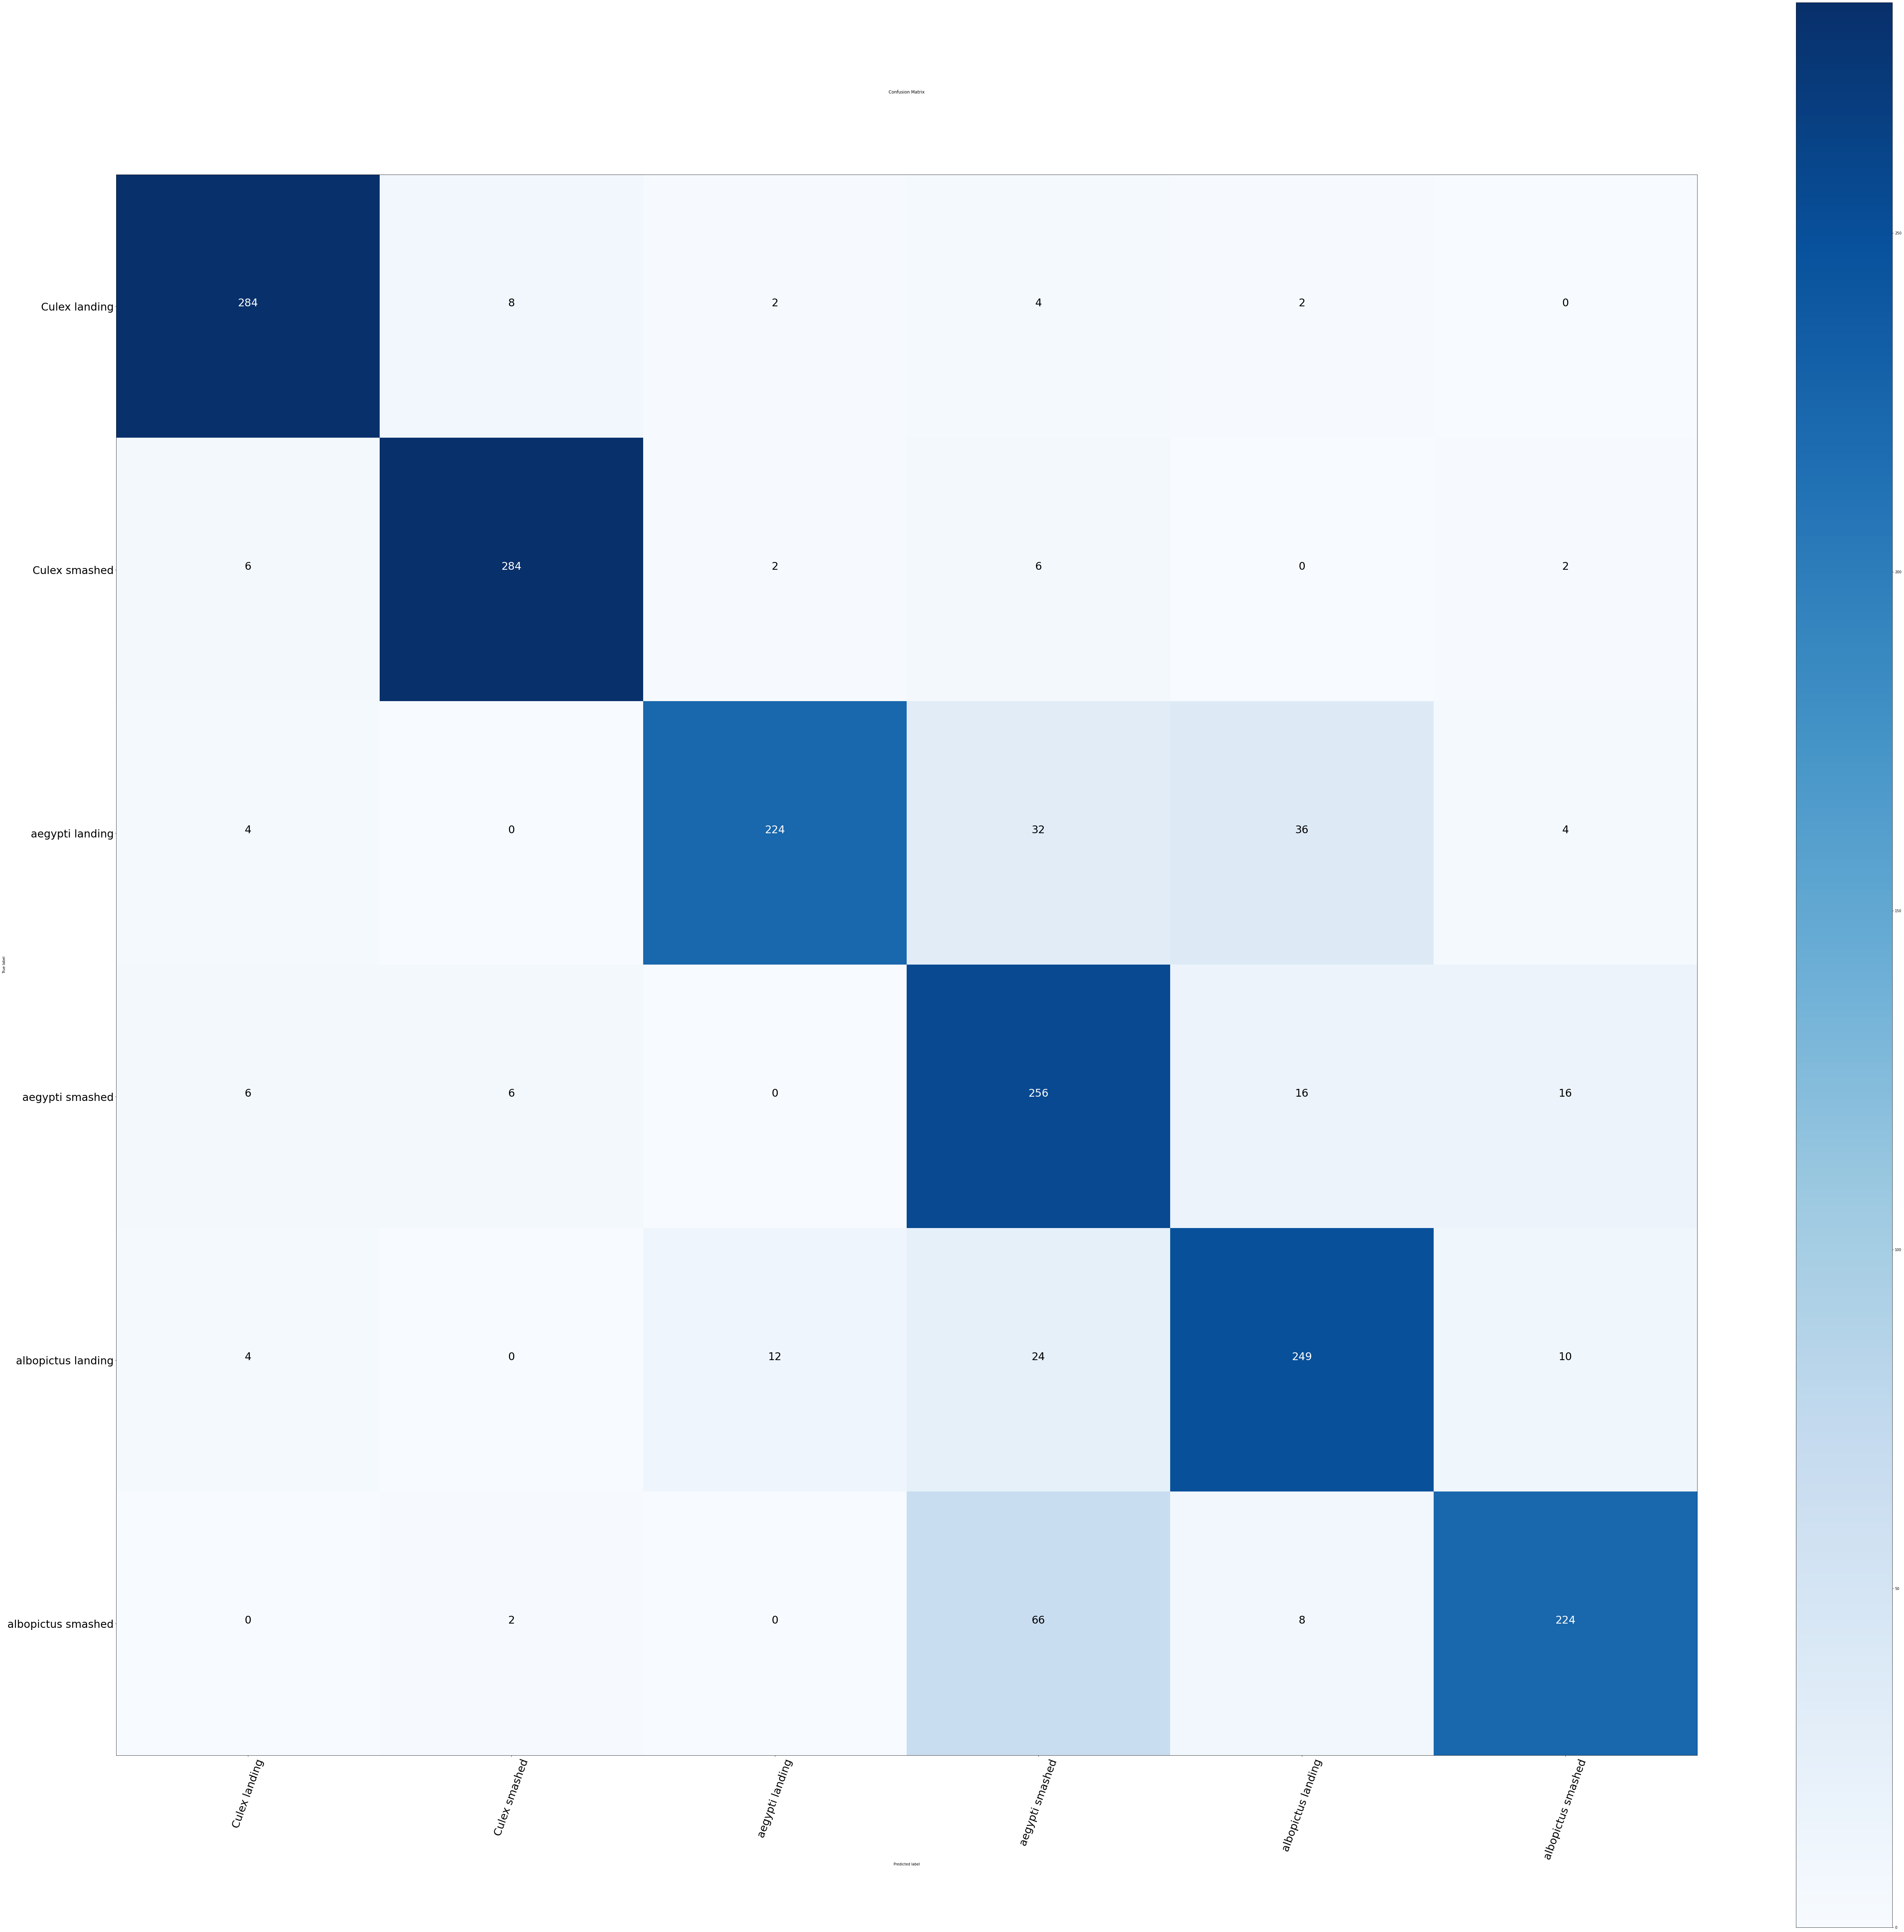

In [ ]:
# Plot a confusion matrix with all 3600 predictions, ground truth labels and 6 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names_test,
                      figsize=(100, 100),
                      text_size=30,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       300
           1       0.95      0.95      0.95       300
           2       0.93      0.75      0.83       300
           3       0.66      0.85      0.74       300
           4       0.80      0.83      0.82       299
           5       0.88      0.75      0.81       300

    accuracy                           0.85      1799
   macro avg       0.86      0.85      0.85      1799
weighted avg       0.86      0.85      0.85      1799



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9403973509933775,
  'precision': 0.9342105263157895,
  'recall': 0.9466666666666667,
  'support': 300},
 '1': {'f1-score': 0.9466666666666667,
  'precision': 0.9466666666666667,
  'recall': 0.9466666666666667,
  'support': 300},
 '2': {'f1-score': 0.8296296296296296,
  'precision': 0.9333333333333333,
  'recall': 0.7466666666666667,
  'support': 300},
 '3': {'f1-score': 0.744186046511628,
  'precision': 0.6597938144329897,
  'recall': 0.8533333333333334,
  'support': 300},
 '4': {'f1-score': 0.8163934426229508,
  'precision': 0.8006430868167203,
  'recall': 0.8327759197324415,
  'support': 299},
 '5': {'f1-score': 0.8057553956834532,
  'precision': 0.875,
  'recall': 0.7466666666666667,
  'support': 300},
 'accuracy': 0.8454697053918844,
 'macro avg': {'f1-score': 0.847171422017951,
  'precision': 0.8582745712609166,
  'recall': 0.8454626532887404,
  'support': 1799},
 'weighted avg': {'f1-score': 0.8471885304000493,
  'precision': 0.8583066065496571,
  'recall': 0

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
    # Append class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Culex landing': 0.9403973509933775,
 'Culex smashed': 0.9466666666666667,
 'aegypti landing': 0.8296296296296296,
 'aegypti smashed': 0.744186046511628,
 'albopictus landing': 0.8163934426229508,
 'albopictus smashed': 0.8057553956834532}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
1,Culex smashed,0.946667
0,Culex landing,0.940397
2,aegypti landing,0.829630
4,albopictus landing,0.816393
5,albopictus smashed,0.805755
3,aegypti smashed,0.744186


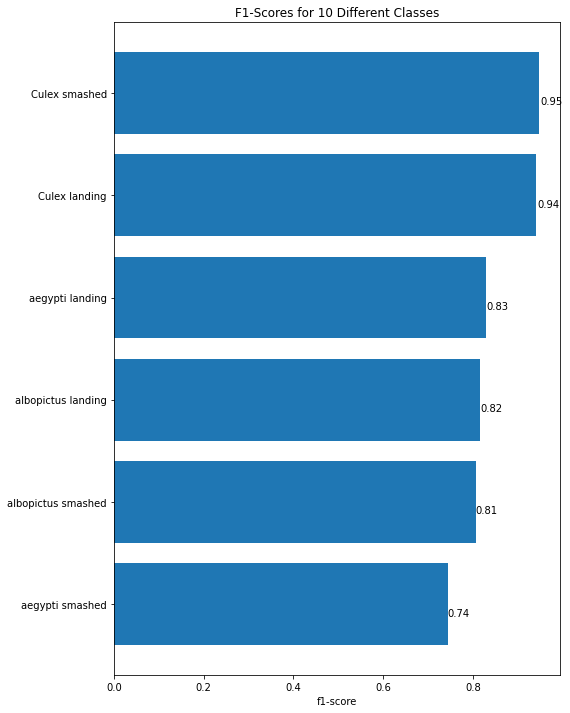

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 12))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def load_and_prep_images(filename, img_shape=224, scale=True):
    """
      Reads in an image from filename, turns it into a tensor and reshapes into
      (224, 224, 3).

      Parameters
      ----------
      filename (str): string filename of target image
      img_shape (int): size to resize target image to, default 224
      scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

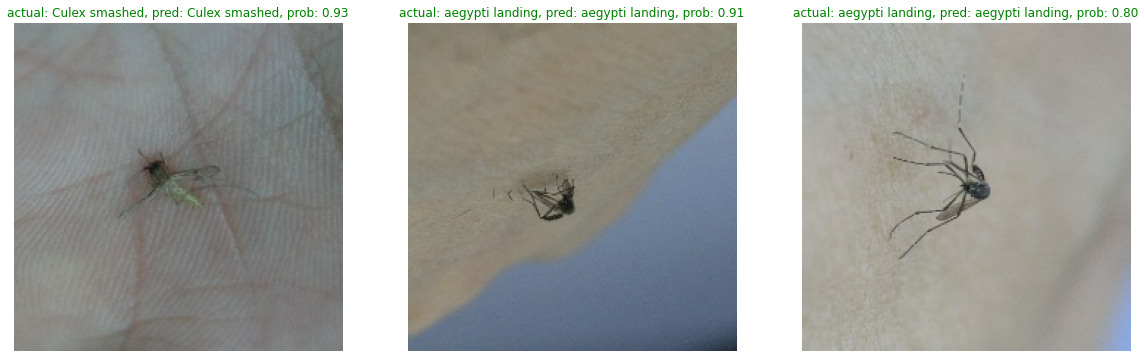

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 14))
for i in range(3):
  # Choose a random image from a random class 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_images(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = model_3.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);


## Fine Tuning

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(6, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_2 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_2 = model_2.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        # Track model training logs
                        callbacks=[create_tensorboard_callback("CNN_learning", "transfer_learning_efficientNet_0")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: CNN_learning/transfer_learning_efficientNet_0/20220804-100038
Epoch 1/10
132/132 [==============================] - 24s 142ms/step - loss: 1.2109 - accuracy: 0.5843 - val_loss: 0.9217 - val_accuracy: 0.7069
Epoch 2/10
132/132 [==============================] - 18s 132ms/step - loss: 0.7948 - accuracy: 0.7471 - val_loss: 0.7132 - val_accuracy: 0.7775
Epoch 3/10
132/132 [==============================] - 18s 137ms/step - loss: 0.6553 - accuracy: 0.7950 - val_loss: 0.6039 - val_accuracy: 0.8156
Epoch 4/10
132/132 [==============================] - 19s 141ms/step - loss: 0.5732 - accuracy: 0.8233 - val_loss: 0.5391 - val_accuracy: 0.8367
Epoch 5/10
132/132 [==============================] - 18s 136ms/step - loss: 0.5244 - accuracy: 0.8338 - val_loss: 0.4851 - val_accuracy: 0.8589
Epoch 6/10
132/132 [==============================] - 17s 131ms/step - loss: 0.4740 - accura

In [ ]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable params: 4,049,571
_________________________________________________________________


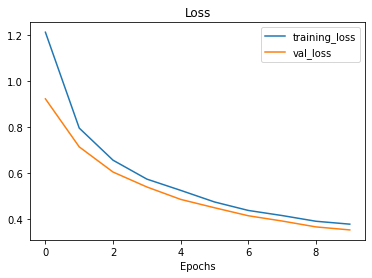

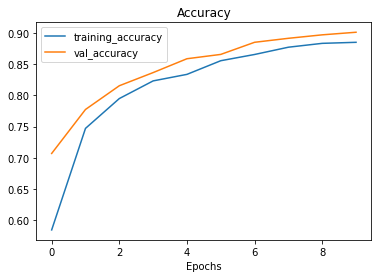

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_2)

In [ ]:
# Make predictions with model
pred_probs = model_2.predict(test_data, verbose=1) # set verbosity to see how long it will take 

57/57 [==============================] - 5s 67ms/step


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8921623123957755

In [ ]:
class_names_test =test_data.class_names

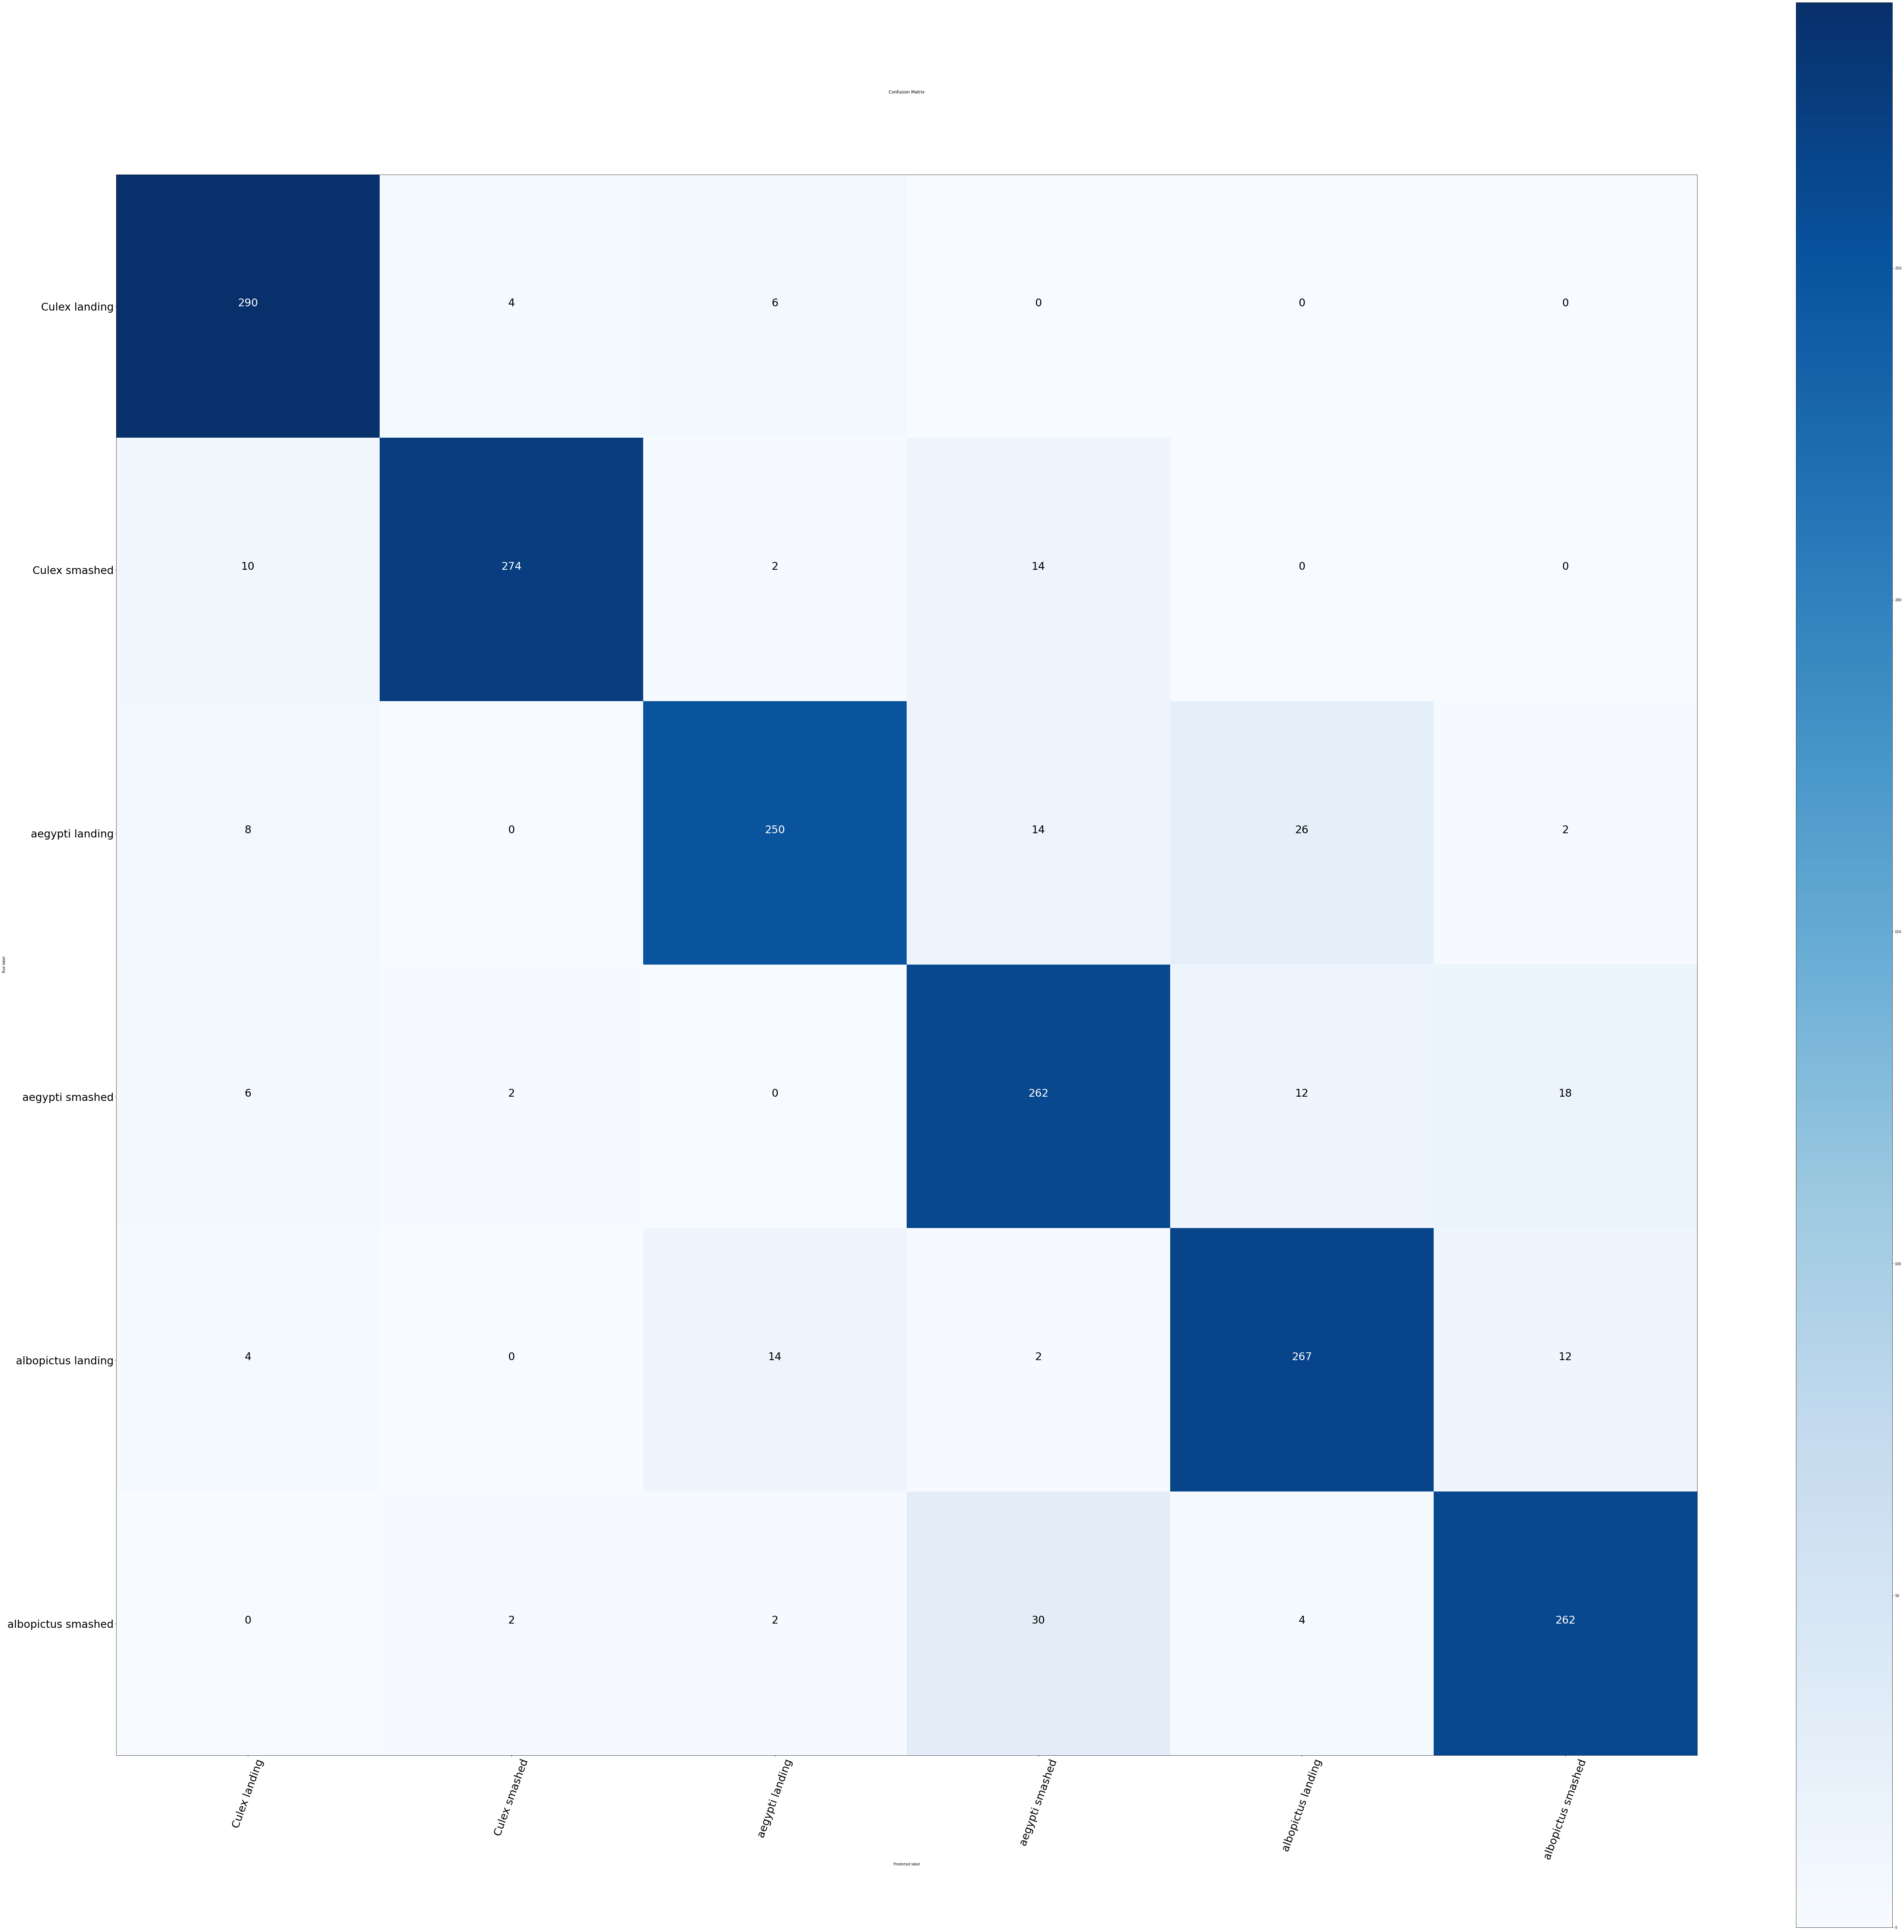

In [ ]:
# Plot a confusion matrix with all 3600 predictions, ground truth labels and 6 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names_test,
                      figsize=(100, 100),
                      text_size=30,
                      norm=False,
                      savefig=True)

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9385113268608414,
  'precision': 0.9119496855345912,
  'recall': 0.9666666666666667,
  'support': 300},
 '1': {'f1-score': 0.9415807560137457,
  'precision': 0.9716312056737588,
  'recall': 0.9133333333333333,
  'support': 300},
 '2': {'f1-score': 0.8710801393728222,
  'precision': 0.9124087591240876,
  'recall': 0.8333333333333334,
  'support': 300},
 '3': {'f1-score': 0.8424437299035369,
  'precision': 0.8136645962732919,
  'recall': 0.8733333333333333,
  'support': 300},
 '4': {'f1-score': 0.8782894736842105,
  'precision': 0.8640776699029126,
  'recall': 0.8929765886287625,
  'support': 299},
 '5': {'f1-score': 0.882154882154882,
  'precision': 0.891156462585034,
  'recall': 0.8733333333333333,
  'support': 300},
 'accuracy': 0.8921623123957755,
 'macro avg': {'f1-score': 0.8923433846650065,
  'precision': 0.8941480631822794,
  'recall': 0.8921627647714604,
  'support': 1799},
 'weighted avg': {'f1-score': 0.892351196733367,
  'precision': 0.894164778242468,
  

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
    # Append class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Culex landing': 0.9385113268608414,
 'Culex smashed': 0.9415807560137457,
 'aegypti landing': 0.8710801393728222,
 'aegypti smashed': 0.8424437299035369,
 'albopictus landing': 0.8782894736842105,
 'albopictus smashed': 0.882154882154882}

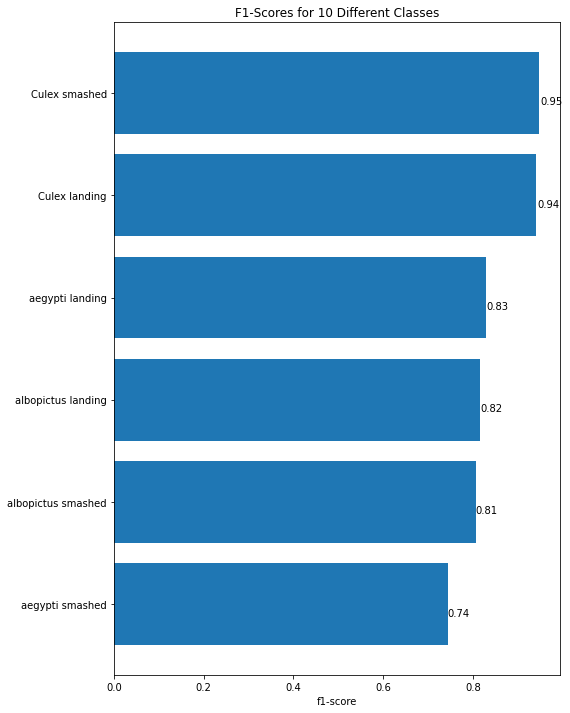

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 12))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Fine Tune Learning Rate and Early Stopping



In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_3 = model_2.fit(train_data,
                                epochs=10, # fine-tune for a maximum of 100 epochs
                                steps_per_epoch=len(train_data),
                                validation_data=val_data,
                                validation_steps=len(val_data), # validation during training on 15% of test data
                                callbacks=[reduce_lr,early_stopping,create_tensorboard_callback("CNN_learning", "transfer_learning_efficientNet_0_tune_lr")]) # reduce the learning rate after X epochs of no improvement



Saving TensorBoard log files to: CNN_learning/transfer_learning_efficientNet_0_tune_lr/20220804-101400
Epoch 1/10
132/132 [==============================] - 24s 142ms/step - loss: 0.3449 - accuracy: 0.8988 - val_loss: 0.3410 - val_accuracy: 0.9042 - lr: 1.0000e-04
Epoch 2/10
132/132 [==============================] - 21s 156ms/step - loss: 0.3471 - accuracy: 0.9029 - val_loss: 0.3387 - val_accuracy: 0.9064 - lr: 1.0000e-04
Epoch 3/10
132/132 [==============================] - 17s 131ms/step - loss: 0.3343 - accuracy: 0.9076 - val_loss: 0.3362 - val_accuracy: 0.9081 - lr: 1.0000e-04
Epoch 4/10
132/132 [==============================] - 18s 132ms/step - loss: 0.3361 - accuracy: 0.9071 - val_loss: 0.3341 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 5/10
132/132 [==============================] - 18s 132ms/step - loss: 0.3378 - accuracy: 0.9021 - val_loss: 0.3322 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 6/10
132/132 [==============================] - 17s 130ms/step - loss: 0.3329 - a

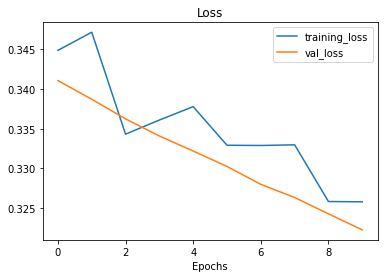

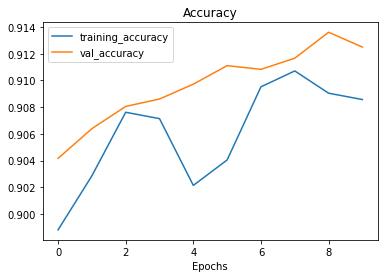

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_3)

In [ ]:
# Make predictions with model
pred_probs = model_2.predict(test_data, verbose=1) # set verbosity to see how long it will take 

57/57 [==============================] - 5s 67ms/step


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9066147859922179

In [ ]:
class_names_test =test_data.class_names

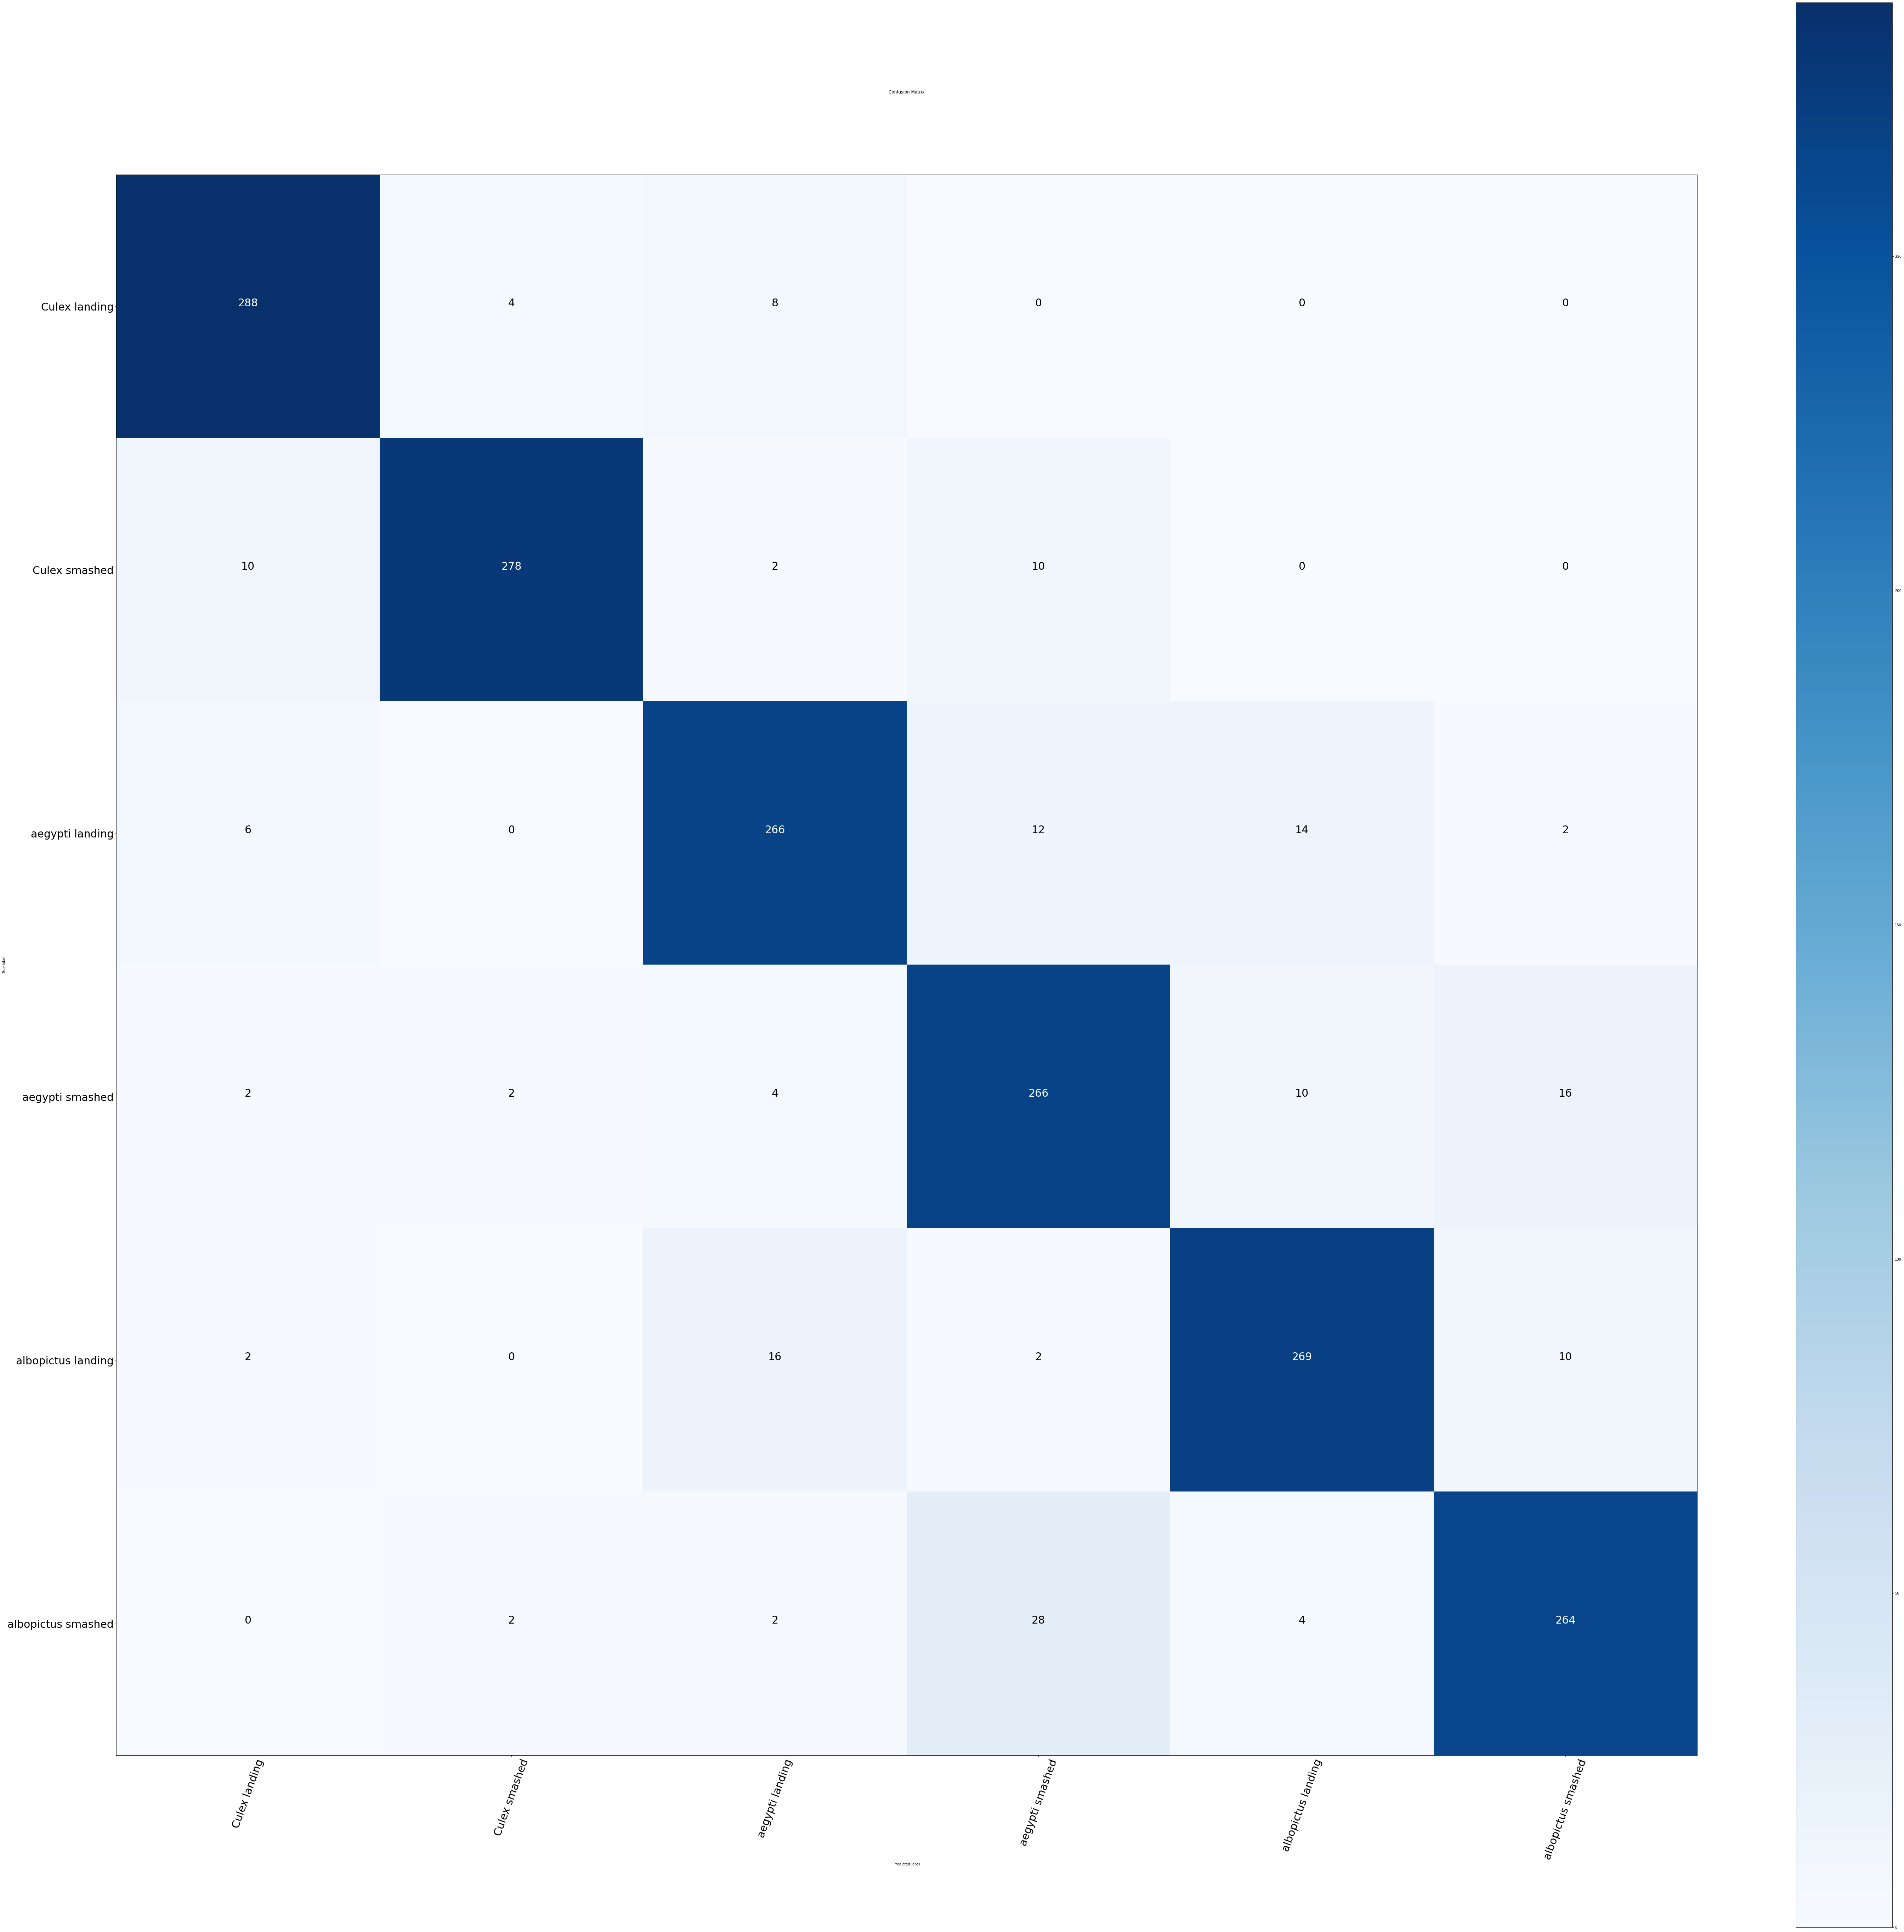

In [ ]:
# Plot a confusion matrix with all 3600 predictions, ground truth labels and 6 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names_test,
                      figsize=(100, 100),
                      text_size=30,
                      norm=False,
                      savefig=True)

In [ ]:
## TensorBoard 
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./CNN_learning \
  --name "Transfer learning and CNN experiments" \
  --description "A series of different transfer learning experiments with fine tune" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/C5T6SJllT2CRwbrOkZXbSQ/

[2022-08-04T10:31:26] Started scanning logdir.
[2022-08-04T10:31:45] Total uploaded: 496 scalars, 0 tensors, 10 binary objects (14.4 MB)
[2022-08-04T10:31:45] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/C5T6SJllT2CRwbrOkZXbSQ/
